## Image Focus and Astigmatism Classifier
- **Author:** [Aaron Woods](https://aaronwoods.info)
- **Date Created:** September 21, 2023
- **Repository:** [Image Classification on VSCode](https://insiders.vscode.dev/tunnel/midnightsim/c:/Users/User/Desktop/Image-Classification)

### Description
This script provides an end-to-end machine learning pipeline for image classification. It can categorize images as "In Focus" or "Out of Focus" while also detecting astigmatism-related issues. The design is modular, making it adaptable to various image classification tasks.

### Features
- Ingests data from Excel spreadsheets.
- Utilizes multiple machine learning models.
- Modular design for easy customization.

### Requirements

In [23]:
# ------------------------------
# Package Installation (Optional)
# ------------------------------
# Uncomment the following lines to install required packages if running on a new machine.

%pip install opencv-python numpy pandas matplotlib protobuf seaborn scikit-learn openpyxl

# ------------------------------
# TensorFlow Installation with GPU Support
# ------------------------------
# Note: TensorFlow versions above 2.10 are not supported on GPUs on native Windows installations.
# For more details, visit: https://www.tensorflow.org/install/pip#windows-wsl2_1

# Uncomment the following line to install TensorFlow if needed.
# %pip install "tensorflow<2.11" --user


In [24]:
# ------------------------------
# System and TensorFlow Info Check
# ------------------------------
import platform
import tensorflow as tf

def get_system_info():
    """Get system and TensorFlow information."""
    system_info = {"Platform": platform.platform(), "Python Version": platform.python_version()}
    
    try:
        system_info.update({
            "TensorFlow Version": tf.__version__,
            "Num GPUs Available": len(tf.config.list_physical_devices('GPU'))
        })
        system_info['Instructions'] = (
            "You're all set to run your model on a GPU." 
            if system_info['Num GPUs Available'] 
            else (
                "No GPUs found. To use a GPU, follow these steps:\n"
                "  1. Install NVIDIA drivers for your GPU.\n"
                "  2. Install a compatible CUDA toolkit.\n"
                "  3. Install the cuDNN library.\n"
                "  4. Make sure to install the GPU version of TensorFlow."
            )
        )
    except ModuleNotFoundError:
        system_info['Instructions'] = (
            "TensorFlow is not installed. "
            "Install it using pip by running: !pip install tensorflow"
        )
    
    return system_info

def configure_gpu_memory_growth():
    """Set GPU memory consumption growth to avoid OOM errors."""
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Call functions to get system info and configure GPU memory.
system_info = get_system_info()
configure_gpu_memory_growth()

# Print system information.
formatted_info = "\n".join(f"{key}: {value}" for key, value in system_info.items())
print(formatted_info)

Platform: Windows-10-10.0.22621-SP0
Python Version: 3.10.9
TensorFlow Version: 2.10.1
Num GPUs Available: 0
Instructions: No GPUs found. To use a GPU, follow these steps:
  1. Install NVIDIA drivers for your GPU.
  2. Install a compatible CUDA toolkit.
  3. Install the cuDNN library.
  4. Make sure to install the GPU version of TensorFlow.


In [25]:
# ------------------------------
# Import Libraries
# ------------------------------

# Standard Libraries
import os
import sys
import random
import math
import glob
import logging
from datetime import datetime
from collections import defaultdict, Counter

# Third-Party Libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils import class_weight, resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, applications
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.data import Dataset
from tensorflow.keras.models import load_model

# Other Imports
import pickle
import itertools
from matplotlib.legend_handler import HandlerTuple

# Type Annotations
from typing import List, Dict, Tuple, Union, Any, Optional


## Configuration

In [26]:
# Configuration Dictionary
experiment_config = {
    'NAME': "PC_balanced_GPU_upsampled",            # Experiment name
    'RANDOM_SEED': 42,                             # Seed for reproducibility
    'PROBLEM_TYPE': 'Multi-Output',                # Problem type: Binary, Multi-Class, Multi-Output, Multi-Label
}

model_config = {
    'IMG_SIZE': 224,                               # Image input size
    'BATCH_SIZE': 16,                              # Batch size for training
    'TRAIN_SIZE': 0.8,                             # Fraction of data to use for training
    'VAL_SIZE': 0.5,                               # Fraction of data to use for validation
    'EPOCHS': 100,                                 # Number of training epochs
    'LEARNING_RATE': 0.001,                        # Learning rate 1e-3
    'EARLY_STOPPING_PATIENCE': 50,                 # Early stopping patience
    'REDUCE_LR_PATIENCE': 3,                       # Reduce learning rate on plateau patience
    'MIN_LR': 1e-6,                                # Minimum learning rate
}

label_mappings = {
    'Focus_Label': {'SharpFocus': 0, 'SlightlyBlurred': 1, 'HighlyBlurred': 2},
    'StigX_Label': {'OptimalStig_X': 0, 'ModerateStig_X': 1, 'SevereStig_X': 2},
    'StigY_Label': {'OptimalStig_Y': 0, 'ModerateStig_Y': 1, 'SevereStig_Y': 2},
}

augmentation_config = {
    'rotation_factor': 0.002,  # Specifies the rotation range applied to the data (in radians).
    'height_factor': (-0.18, 0.18),  # Specifies the range of random vertical shifts applied to the data.
    'width_factor': (-0.18, 0.18),  # Specifies the range of random horizontal shifts applied to the data.
    'contrast_factor': 0.5,  # Specifies the range of random contrast adjustments applied to the data.
}

# Combine Experiment, Model, Labels, and Augmentation Configurations
config = {
    'Experiment': experiment_config,
    'Model': model_config,
    'Labels': {'MAPPINGS': label_mappings},
    'Augmentation': augmentation_config
}

# Dataset Creation Configuration
csv_config = {
    'CSV': {
        'COLUMNS_TO_READ': ['ImageFile', 'Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']
    },
    'Thresholds': {
        'FOCUS_LOW': 30,                              # Lower focus threshold
        'FOCUS_HIGH': 60,                             # Upper focus threshold
        
        'STIGX_LOW': 1,                               # Lower astigmatism threshold
        'STIGX_HIGH': 2,                              # Upper astigmatism threshold
        
        'STIGY_LOW': 1,                               # Lower astigmatism threshold
        'STIGY_HIGH': 2,                              # Upper astigmatism threshold
    },
    'Paths': {
        'OLD_BASE_PATH': "D:\\DOE\\",
        
        # On Simulation Computer
        # 'DATA_FILE': "combined_output.csv",
        # 'NEW_BASE_PATH': "Y:\\User\\Aaron-HX38\\DOE\\", 
        
        # On Laptop
        'DATA_FILE': "combined_output_cleaned.csv",
        'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Desktop\\Dec 24\\",
    },
    'SAMPLE_FRAC': 1,                                # Fraction of the data for quicker prototyping (1.0 means use all data)
}

# Update the main configuration dictionary with the dataset configuration
config.update(csv_config)

# Set random seed for reproducibility
np.random.seed(config['Experiment']['RANDOM_SEED'])
tf.random.set_seed(config['Experiment']['RANDOM_SEED'])

## Data Loading and Preprocessing

In [27]:
### Functions for Preparation of CSV

def read_csv(config: Dict):
    # Functionality to read the data
    data_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"Error: File does not exist - {data_file_path}")
    try:
        data = pd.read_csv(data_file_path, usecols=config['CSV']['COLUMNS_TO_READ'])
        print("---> Data read successfully.")
        sample_frac = config.get('SAMPLE_FRAC', 1.0)
        if 0 < sample_frac < 1.0:
            data = data.sample(frac=sample_frac).reset_index(drop=True)
            print(f"---> Data sampled: Using {sample_frac * 100}% of the available data.")
    except Exception as e:
        raise ValueError(f"Error: Could not read data - {e}") from e
    return data

def update_image_paths(df):
    old_base_path = config['Paths']['OLD_BASE_PATH']
    new_base_path = config['Paths']['NEW_BASE_PATH']
    df['ImageFile'] = df['ImageFile'].str.replace(old_base_path, new_base_path, regex=False)
    print("---> Image paths updated.")
    return df


def clean_csv(df: pd.DataFrame, save_cleaned: bool = False) -> pd.DataFrame:
    def is_valid_string(image_path) -> bool:
        return isinstance(image_path, str)
    
    def does_file_exist(image_path) -> bool:
        return os.path.exists(image_path)
    
    def can_image_be_read(image_path) -> bool:
        img = cv2.imread(image_path)
        return img is not None
    
    removal_reasons = defaultdict(list)
    total_rows = len(df)
    csv_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    print("Cleaning CSV file...")
    for index, row in enumerate(df.itertuples()):
        progress = (index + 1) / total_rows * 100
        print(f"\rProgress: {progress:.2f}%", end="")
        
        image_path = row.ImageFile
        reason = None
        
        if not is_valid_string(image_path):
            reason = "Invalid ImageFile value - not a string"
        elif not does_file_exist(image_path):
            reason = "File does not exist"
        elif not can_image_be_read(image_path):
            reason = "Image can't be read"
        
        if reason:
            removal_reasons[reason].append(index)
    
    invalid_rows = [index for indices in removal_reasons.values() for index in indices]
    df.drop(index=invalid_rows, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print("\n\nSummary of row removals:")
    for reason, indices in removal_reasons.items():
        print(f"{len(indices)} rows removed due to: {reason}")
        print(f"Row indices: {indices}")
    
    if save_cleaned and csv_file_path:
        cleaned_csv_file_path = f"{os.path.splitext(csv_file_path)[0]}_cleaned.csv"
        df.to_csv(cleaned_csv_file_path, index=False)
        print(f"Cleaned CSV saved to: {cleaned_csv_file_path}")
    
    return df


In [28]:
### Generating labels

def generate_thresholds(label_key):
    low_key = f"{label_key.split('_')[0].upper()}_LOW"
    high_key = f"{label_key.split('_')[0].upper()}_HIGH"
    return config.get('Thresholds', {}).get(low_key, 0), config.get('Thresholds', {}).get(high_key, 0)

def generate_single_label(df_copy, label_key, offset_column, choices_dict):
    low_threshold, high_threshold = generate_thresholds(label_key)
    conditions = [
        (df_copy[offset_column].abs() <= low_threshold),
        (df_copy[offset_column].abs() > low_threshold) & (df_copy[offset_column].abs() <= high_threshold),
        (df_copy[offset_column].abs() > high_threshold)
    ]
    choices = list(choices_dict.keys())
    df_copy[label_key] = np.select(conditions, choices, default='Unknown')
    le = LabelEncoder()
    df_copy[label_key] = le.fit_transform(df_copy[label_key])
    return le

def generate_labels(df: pd.DataFrame):
    print("---> Generating labels for Focus, StigX, and StigY...")
    labels_config = config.get('Labels', {}).get('MAPPINGS', {})
    offset_column_mapping = {'Focus_Label': 'Focus_Offset (V)', 'StigX_Label': 'Stig_Offset_X (V)', 'StigY_Label': 'Stig_Offset_Y (V)'}

    df_copy = df.copy()
    label_encoders = {}

    for label_key, choices_dict in labels_config.items():
        offset_column = offset_column_mapping.get(label_key)
        if not offset_column:
            print(f"Warning: No offset column mapping found for '{label_key}'. Skipping label generation.")
            continue
        if offset_column not in df.columns:
            print(f"Warning: Column '{offset_column}' not found in DataFrame. Skipping label generation for '{label_key}'.")
            continue
        label_encoders[label_key] = generate_single_label(df_copy, label_key, offset_column, choices_dict)
        print(f"---> Labels generated for {label_key}")

    if config.get('Experiment', {}).get('PROBLEM_TYPE') == 'Multi-Output':
        df_copy['Multi_Output_Labels'] = df_copy.apply(lambda row: [row[key] for key in labels_config.keys()], axis=1)
        print("---> Multi-Output Labels generated.")
        
    return df_copy, label_encoders


In [29]:
### Shuffling and Splitting the Data

def shuffle_and_reset_index(data):
    print("---> Shuffling and resetting index...")
    shuffled_df = data.sample(frac=1, random_state=config['Experiment']['RANDOM_SEED']).reset_index(drop=True)
    print("---> Data shuffled and index reset.")
    return shuffled_df

def prepare_datasets(df: pd.DataFrame):
    """Prepare training, validation, and test datasets."""
    # Check if DataFrame is empty
    if df is None or df.empty:
        print("Warning: DataFrame is empty. Cannot proceed with data preparation.")
        return {'train': None, 'valid': None, 'test': None}
    # Split Data
    try:
        train_df, temp_df = train_test_split(df, test_size=1 - config['Model']['TRAIN_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
        val_df, test_df = train_test_split(temp_df, test_size=1 - config['Model']['VAL_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
    except ValueError:
        print("Not enough data to split into training, validation, and test sets.")
        return {'train': None, 'valid': None, 'test': None}
    print("---> Data split into training, validation, and test sets.")
    return {'train': train_df, 'valid': val_df, 'test': test_df}

In [30]:
### Computting Class Weights

def compute_class_weights_for_label(split: str, df: pd.DataFrame, label: str, label_encoders: Dict[str, LabelEncoder], all_records: List[Dict], is_multi_label: bool = False) -> None:
    y_data = df[label].values if is_multi_label else df[label]
    unique_labels = np.unique(y_data)
    class_weights = compute_class_weight('balanced', classes=unique_labels, y=y_data)
    class_weights_dict = dict(zip(unique_labels, class_weights))
    
    for cls, weight in class_weights_dict.items():
        cnt = Counter(y_data)[cls]
        original_class = label_encoders[label].inverse_transform([cls])[0]
        all_records.append({
            'split': split,
            'label': label,
            'class': original_class,
            'Count': cnt,
            'Weight': weight
        })

def compute_and_store_class_weights(datasets: Dict[str, pd.DataFrame], label_encoders: Dict[str, LabelEncoder]) -> pd.DataFrame:
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE', 'Binary')
    all_records = []
    
    for split, df in datasets.items():
        if df is None:
            continue
        for label in config['Labels']['MAPPINGS']:
            compute_class_weights_for_label(
                split, df, label, label_encoders, all_records, 
                is_multi_label=(problem_type == 'Multi-label')
            )
                
    df_class_weights = pd.DataFrame.from_records(all_records)
    df_class_weights.set_index(['split', 'label', 'class'], inplace=True)
    return df_class_weights

In [31]:
### Creating Tensorflow Datasets

def create_tf_datasets_from_dfs(dfs: Dict[str, pd.DataFrame], include_offset: bool = False) -> Dict[str, Dict[str, Any]]:
    """
    Create TensorFlow datasets from DataFrames for training, validation, and testing.
    """
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE')
    batch_size = config.get('Model', {}).get('BATCH_SIZE', 32)
    AUTOTUNE = tf.data.AUTOTUNE
    
    preprocessing_layers = create_preprocessing_layers()
    augmentation_layers = create_augmentation_layers()
    
    def load_and_preprocess_image(file_path: tf.Tensor, label: tf.Tensor, offset: Optional[tf.Tensor], augment: bool = False) -> Tuple:
        file_path_str = file_path.numpy().decode('utf-8')
        image = read_and_convert_image(file_path_str)
        image = preprocessing_layers(image)
        if augment:
            image = augmentation_layers(image)
            image = tf.clip_by_value(image, 0.0, 1.0)
        label = tf.cast(label, tf.int32)
        offset = tf.cast(offset, tf.float32) if offset is not None else None
        return (image, label, offset) if include_offset else (image, label)

    def prepare_dataset(file_paths, labels, offsets, augment):
        ds = tf.data.Dataset.from_tensor_slices((file_paths, labels, offsets))
        ds = ds.map(lambda file_path, label, offset: tf.py_function(
            func=load_and_preprocess_image,
            inp=[file_path, label, offset if offset is not None else tf.constant([], dtype=tf.float32), augment],
            Tout=[tf.float32, label.dtype, tf.float32] if include_offset else [tf.float32, label.dtype]
        ))
        return ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE) # If I have a lot of memory, I can use cache() here.

    tf_datasets = {'train': {}, 'valid': {}, 'test': {}}
    offset_column_mapping = {
        'Focus_Label': 'Focus_Offset (V)',
        'StigX_Label': 'Stig_Offset_X (V)',
        'StigY_Label': 'Stig_Offset_Y (V)'
    }

    for split, df in dfs.items():
        augment_data = (split == 'train')
        if problem_type in ['Multi-Class', 'Binary']:
            for label in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
                offset_column = offset_column_mapping.get(label)
                offsets = df[offset_column].values if include_offset else None
                tf_datasets[split][label] = prepare_dataset(df['ImageFile'].values, df[label].values, offsets, augment_data)
        
        elif problem_type == 'Multi-Output':
            labels = df[['Focus_Label', 'StigX_Label', 'StigY_Label']].values
            offsets = df[['Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']].values if include_offset else None
            tf_datasets[split]['Multi_Output'] = prepare_dataset(df['ImageFile'].values, labels, offsets, augment_data)
        
        else:
            print("Unknown problem type specified in config. Please check.")

    return tf_datasets

### Image Augmentation and Preprocessing

def create_preprocessing_layers() -> keras.Sequential:
    """Create preprocessing layers for resizing and rescaling images."""
    img_size = config['Model']['IMG_SIZE']
    return keras.Sequential([
        layers.Resizing(img_size, img_size),
        layers.Rescaling(1./255)
    ])

def create_augmentation_layers() -> keras.Sequential:
    """Create data augmentation layers."""
    aug_config = config['Augmentation']
    try:
        return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(aug_config['rotation_factor']),
            layers.RandomTranslation(
                height_factor=aug_config['height_factor'],
                width_factor=aug_config['width_factor'],
                fill_mode="reflect"
            ),
            layers.RandomContrast(aug_config['contrast_factor']),
        ])
        
    except Exception as e:
        print(f"An error occurred while creating augmentation layers: {e}")
        return None

def read_and_convert_image(file_path: str) -> tf.Tensor:
    """Read an image from a file and convert it to a 3-channel tensor."""
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Failed to read the image.")
        return None
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    return tf.image.grayscale_to_rgb(image)

In [32]:
### Resample Datasets to deal with Imbalances (Optional)

def validate_inputs(datasets: Dict[str, pd.DataFrame], resample_label: str, resample_strategy: str) -> None:
    if not isinstance(datasets, dict):
        raise ValueError("Input datasets should be a dictionary.")
    if resample_strategy not in ["upsample", "downsample", "combined"]:
        raise ValueError("Invalid resample_strategy. Choose from 'upsample', 'downsample', or 'combined'.")
    for key, df in datasets.items():
        if resample_label not in df.columns:
            raise ValueError(f"'{resample_label}' is not a valid column in the {key} dataset.")

def target_count_for_strategy(label_counts: pd.Series, strategy: str) -> int:
    if strategy == "downsample":
        return label_counts.min()
    elif strategy == "upsample":
        return label_counts.max()
    return int(label_counts.median())

def iterative_resampling(df: pd.DataFrame, resample_strategy: str, resample_label: str) -> pd.DataFrame:
    label_counts = df[resample_label].apply(tuple).value_counts()
    target_count = target_count_for_strategy(label_counts, resample_strategy)
    subsets = [
        resample(
            df[df[resample_label].apply(tuple) == unique_label],
            replace=(label_counts[unique_label] < target_count),
            n_samples=target_count
        )
        for unique_label in label_counts.keys()
    ]
    return pd.concat(subsets).sample(frac=1).reset_index(drop=True)

def resample_datasets(datasets: Dict[str, pd.DataFrame], resample_label='Multi_Output_Labels', resample_strategy="downsample") -> Dict[str, pd.DataFrame]:
    validate_inputs(datasets, resample_label, resample_strategy)
    
    int32_columns = [col for col, dtype in datasets.get('train', pd.DataFrame()).dtypes.items() if dtype == 'int32']
    
    def process_dataset(key: str, df: pd.DataFrame) -> pd.DataFrame:
        if key != 'train':
            return df
        resampled_data = iterative_resampling(df, resample_strategy, resample_label)
        for col in int32_columns:
            resampled_data[col] = resampled_data[col].astype('int32')
        return resampled_data
    
    return {key: process_dataset(key, df) for key, df in datasets.items()}


In [33]:
# 🚀 Enhanced Data Loading and Preprocessing Workflow

print("\n🔍 [START] Preprocessing CSV Data...")
data = read_csv(config)
data = update_image_paths(data)
# Uncomment the below line if you want to clean the CSV
# data = clean_csv(data, save_cleaned=True)
data, label_encoders = generate_labels(data)
data = shuffle_and_reset_index(data)

print("\n📊 [LOAD] Preparing TensorFlow Datasets...")
datasets = prepare_datasets(data)
print("  🏋️‍♂️ Computing class weights for original datasets...")
df_class_weights = compute_and_store_class_weights(datasets, label_encoders)

print("\n  🔁 Resampling datasets... (Optional)")
resampled_datasets = resample_datasets(datasets, resample_label='Multi_Output_Labels', resample_strategy="upsample")
print("  🏋️‍♀️ Computing class weights for resampled datasets...")
rdf_class_weights = compute_and_store_class_weights(resampled_datasets, label_encoders)

print("\n🔧 [BUILD] Creating TensorFlow datasets from DataFrames...")
datasets = create_tf_datasets_from_dfs(datasets, include_offset=True)
resampled_datasets = create_tf_datasets_from_dfs(resampled_datasets, include_offset=True)

print("\n✅ [DONE] Preprocessing Complete!\n")



🔍 [START] Preprocessing CSV Data...
---> Data read successfully.
---> Image paths updated.
---> Generating labels for Focus, StigX, and StigY...
---> Labels generated for Focus_Label
---> Labels generated for StigX_Label
---> Labels generated for StigY_Label
---> Multi-Output Labels generated.
---> Shuffling and resetting index...
---> Data shuffled and index reset.

📊 [LOAD] Preparing TensorFlow Datasets...
---> Data split into training, validation, and test sets.
  🏋️‍♂️ Computing class weights for original datasets...

  🔁 Resampling datasets... (Optional)
  🏋️‍♀️ Computing class weights for resampled datasets...

🔧 [BUILD] Creating TensorFlow datasets from DataFrames...

✅ [DONE] Preprocessing Complete!



## Visualizing the Data

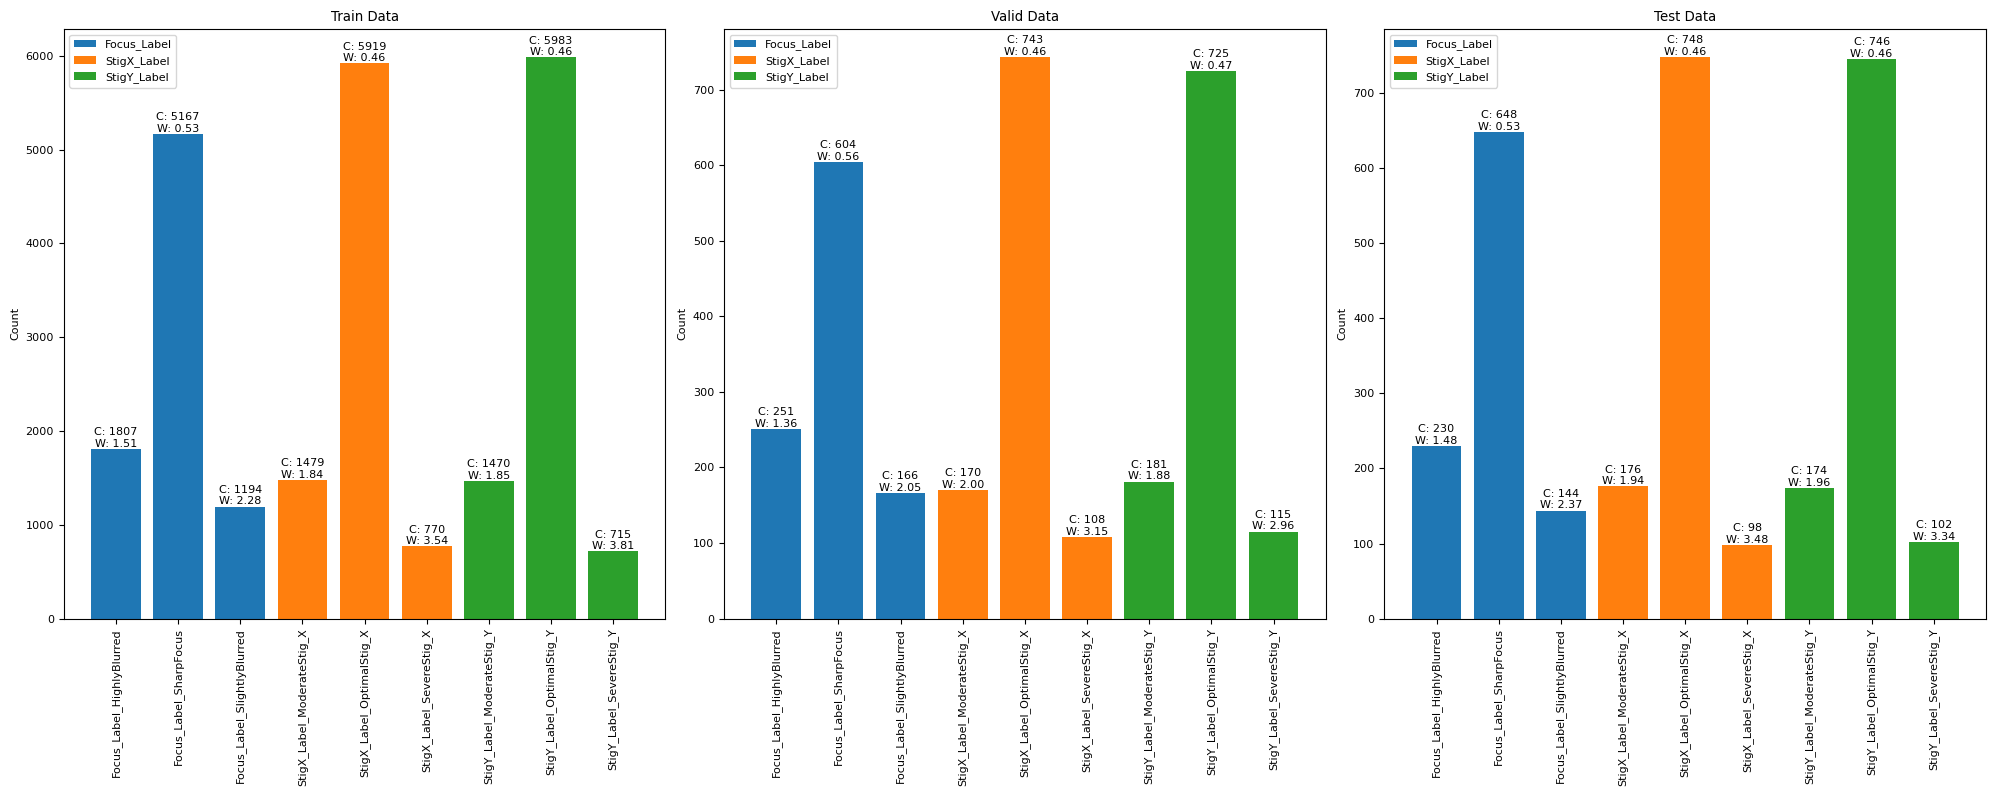

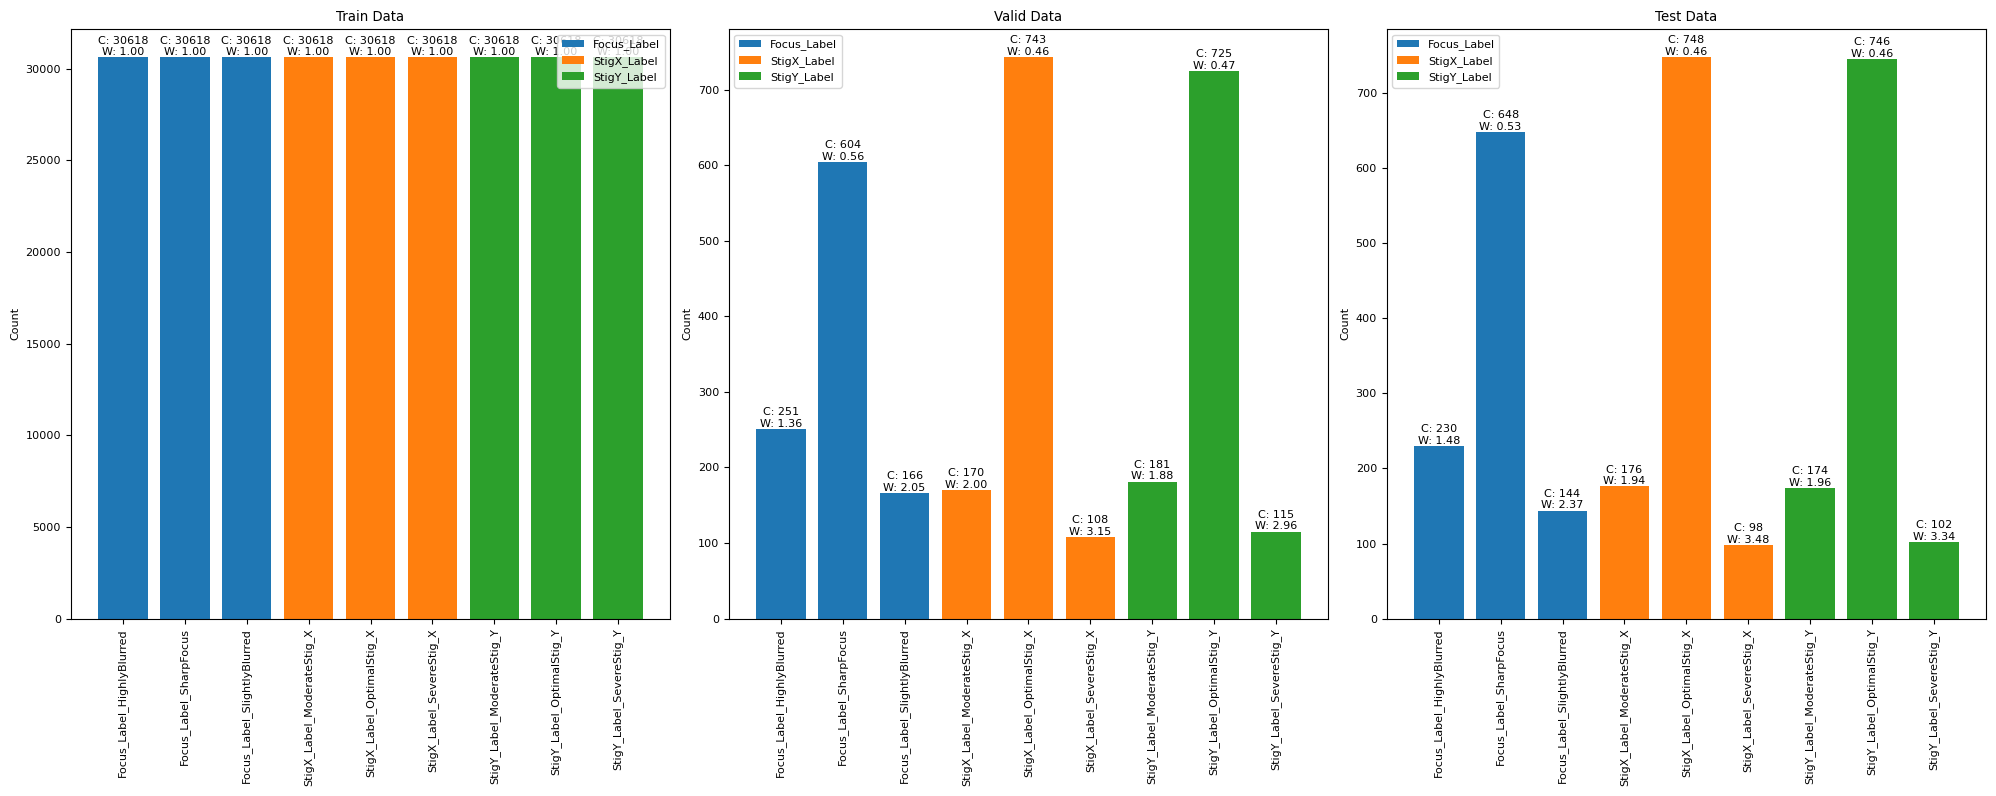

In [34]:
### Class Distributions
import matplotlib.pyplot as plt

def add_annotations(ax, bars, sub_df):
    """
    Adds annotations to the bars.
    """
    for bar, (_, row) in zip(bars, sub_df.iterrows()):
        x = bar.get_x() + bar.get_width() / 2.0
        y = bar.get_height() + 0.5  # Shift annotation slightly above the bar for clarity
        ax.annotate(f"C: {int(row['Count'])}\nW: {row['Weight']:.2f}", 
                    (x, y), 
                    ha='center', 
                    va='bottom', 
                    fontsize=8)

def plot_single_split(ax, df, split):
    """
    Plots the class distribution for a single split (train/test/valid).
    """
    filtered_df = df.loc[split]
    x_ticks = []
    x_tick_locs = []
    current_x = 0  # Keep track of the current x-location for ticks
    
    labels = filtered_df.index.get_level_values('label').unique()
    for label in labels:
        sub_df = filtered_df.loc[label]
        bars = ax.bar(sub_df.index, sub_df['Count'], label=f"{label}")
        add_annotations(ax, bars, sub_df)
        
        x_ticks.extend([f"{label}_{cls}" for cls in sub_df.index])
        x_tick_locs.extend([current_x + i for i in range(len(sub_df.index))])
        current_x += len(sub_df.index)  # Update the x-location for the next set of bars
    
    ax.legend()
    ax.set_xticks(x_tick_locs)  # Set tick locations
    ax.set_xticklabels(x_ticks, rotation=90, fontsize=8)  # Set tick labels
    ax.set_title(f"{split.capitalize()} Data")
    ax.set_ylabel("Count")  # Indicate that the bars represent counts


def plot_dataset_info(df):
    """
    Plots the class distribution for train, valid, and test splits.
    """
    splits = ['train', 'valid', 'test']
    fig, axs = plt.subplots(1, len(splits), figsize=(20, 8))
    
    for i, split in enumerate(splits):
        plot_single_split(axs[i], df, split)
        
    plt.tight_layout()
    plt.show()

# Example usage
plot_dataset_info(df_class_weights)
plot_dataset_info(rdf_class_weights)


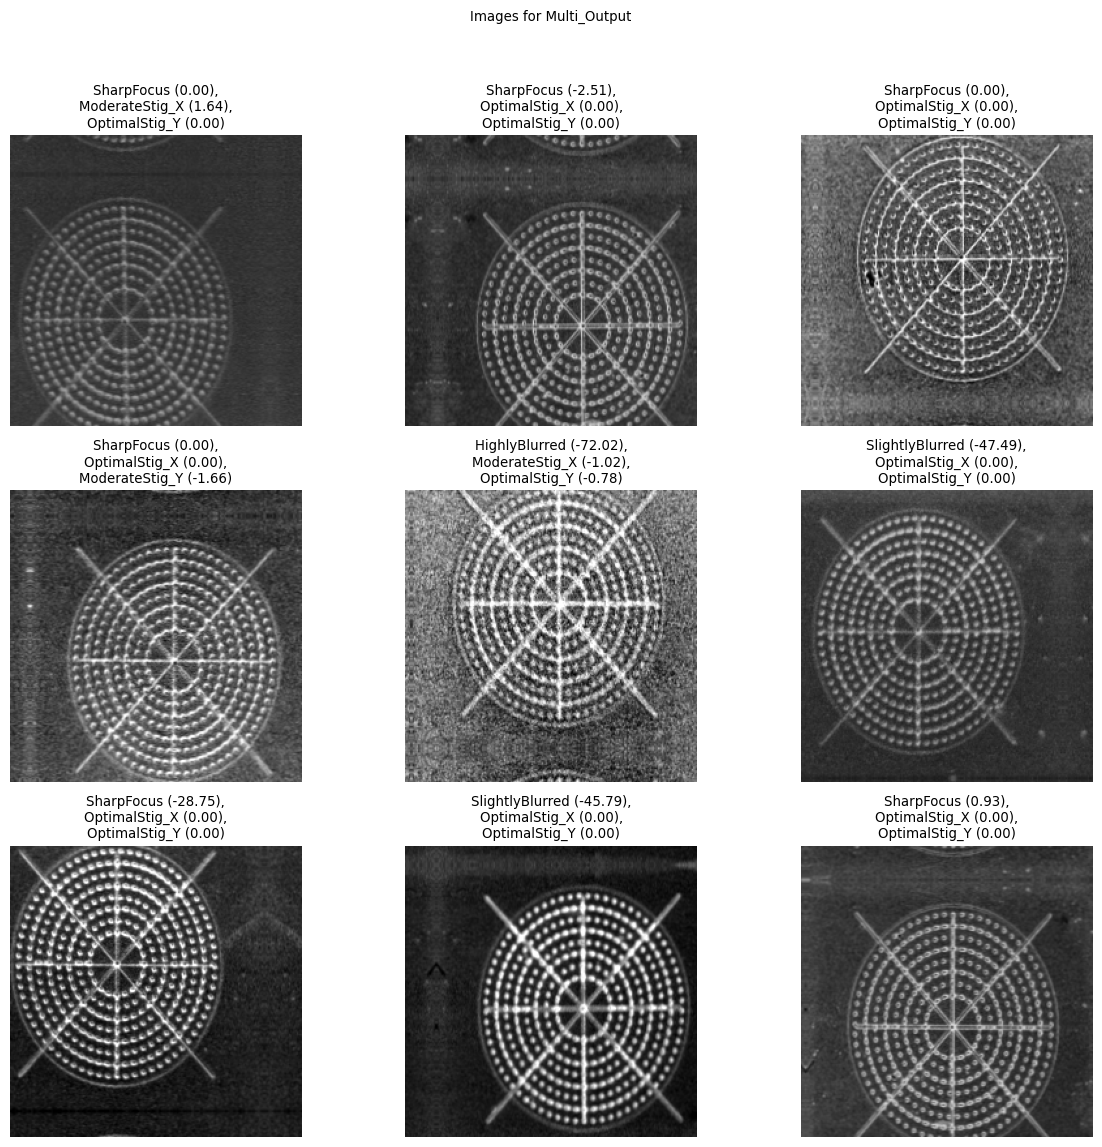

In [35]:
### Plot Images from Dataset

import textwrap
import matplotlib.pyplot as plt

def plot_single_image(ax, image, label_names, offsets):
    """
    Plots a single image with associated labels and offsets.
    """
    ax.imshow(image)
    title_text = ", ".join(f"{name} ({offset})" for name, offset in zip(label_names, offsets))
    ax.set_title("\n".join(textwrap.wrap(title_text, 30)))  # Wrap text to fit into the subplot
    ax.axis("off")

def extract_and_transform_labels(labels, label_keys, label_encoders):
    """
    Extracts and transforms labels using label encoders.
    """
    label_names = []
    for label_value, label_key in zip(labels, label_keys):
        label_encoder = label_encoders.get(label_key, None)
        if label_encoder:
            label_names.append(label_encoder.inverse_transform([label_value])[0])
        else:
            label_names.append(str(label_value))
    return label_names

def plot_images_from_dataset(label_encoders, config, datasets):
    """
    Plots images, labels, and offsets (if available) from the provided datasets.
    
    Args:
        label_encoders (dict): Dictionary of label encoders for each label key.
        config (dict): Configuration dictionary containing problem type and other parameters.
        datasets (dict): Dictionary of datasets, containing training data for each label key.
    """
    label_keys = ['Focus_Label', 'StigX_Label', 'StigY_Label']
    problem_type = config['Experiment']['PROBLEM_TYPE']

    plt.rcParams.update({'font.size': 8})
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    # Helper function to get relevant dataset based on problem type
    def get_relevant_dataset(problem_type, label_key):
        return datasets['train'][label_key if problem_type in ['Multi-Class', 'Binary'] else 'Multi_Output']

    # If problem type is not Multi-Output, re-use the same logic for both Binary and Multi-Class
    relevant_datasets = [label_keys] if problem_type != "Multi-Output" else ["Multi_Output"]

    for label_key in relevant_datasets:
        label_encoder = label_encoders.get(label_key, None)
        fig.suptitle(f"Images for {label_key}")

        for data in get_relevant_dataset(problem_type, label_key).take(1):
            images, labels = data[:2]
            offsets = data[2] if len(data) > 2 else None

            for i in range(min(len(images), 9)):
                ax = axes[i // 3, i % 3]
                current_labels = labels[i].numpy() if problem_type == "Multi-Output" else [labels[i].numpy()]
                current_offsets = offsets[i].numpy() if offsets is not None else ["N/A"] * len(label_keys)
                # Round offsets to 2 decimal places
                current_offsets = [f"{offset:.2f}" for offset in current_offsets]

                label_names = extract_and_transform_labels(current_labels, label_keys, label_encoders)
                plot_single_image(ax, images[i].numpy(), label_names, current_offsets)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    if problem_type not in ["Multi-Class", "Binary", "Multi-Output"]:
        print("Unknown problem type specified in config. Please check.")

# Example usage (assuming label_encoders, config, and datasets are defined elsewhere)
plot_images_from_dataset(label_encoders, config, datasets)


## Creating Classification Models

In [54]:
### Model Building (Define the Model)

def add_multi_output_heads(base_layer, num_classes: int, output_names: List[str]) -> List[keras.layers.Layer]:
    """Creates multiple output heads for a given base layer."""
    outputs = []
    for i in range(num_classes):
        x = layers.Dense(128, activation="relu")(base_layer)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(3, activation="softmax", name=output_names[i])(x)  # Naming each output layer
        outputs.append(x)
    return outputs

def determine_activation_and_units(num_classes: int) -> Tuple[List[str], List[int]]:
    """Determines the activation functions and units based on the number of classes and config settings."""
    problem_type = config.get('Experiment').get('PROBLEM_TYPE')
    if problem_type in ['Multi-Label', 'Binary', 'Multi-Class', 'Multi-Output']:
        return {
            'Multi-Label': (["sigmoid"] * num_classes, [1] * num_classes),
            'Binary': (["sigmoid"], [1]),
            'Multi-Class': (["softmax"], [num_classes]),
            'Multi-Output': (["softmax"] * num_classes, [3] * num_classes)  # Assuming each output has 3 classes
        }[problem_type]
    raise ValueError(f"Invalid problem_type: {problem_type}")

def create_transfer_model(base_model, input_shape: Tuple[int, int, int], num_classes: int, hidden_units: List[int], dropout_rate: float, regularizer_rate: float, output_names: List[str] = None) -> keras.Model:
    """Creates a transfer learning model based on the provided base model."""
    base_model.trainable = False
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])
    for units in hidden_units:
        model.add(layers.Dense(units, kernel_regularizer=keras.regularizers.l2(regularizer_rate), bias_regularizer=keras.regularizers.l2(regularizer_rate)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(dropout_rate))
    
    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        model.add(layers.Dense(units_list[0], activation=activations[0]))
        return model
    
    # output_names = output_names or list(config['Labels']['MAPPINGS'].keys())
    output_names = list(config['Labels']['MAPPINGS'].keys())

    outputs = add_multi_output_heads(model.layers[-1].output, num_classes, output_names)
    return keras.Model(inputs=model.input, outputs=outputs)

def create_specific_transfer_model(base_model_class, input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    """Helper function to create specific transfer models."""
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001, output_names=config['Labels']['MAPPINGS'].keys())

def create_mobilenetv2_transfer_model(input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    return create_specific_transfer_model(tf.keras.applications.MobileNetV2, input_shape, num_classes)

def create_inceptionv3_transfer_model(input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    return create_specific_transfer_model(tf.keras.applications.InceptionV3, input_shape, num_classes)

def create_resnet50_transfer_model(input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    return create_specific_transfer_model(tf.keras.applications.ResNet50, input_shape, num_classes)

# Define the function to create a basic CNN model
def create_basic_cnn_model(input_shape, num_classes):
    conv2d_filter_size = (3, 3)
    conv2d_activation = 'relu'
    dense_activation = 'relu'
    num_conv_blocks = 3

    inputs = keras.Input(shape=input_shape)

    x = inputs

    for _ in range(num_conv_blocks):
        x = layers.Conv2D(32 * (2**_), conv2d_filter_size, activation=conv2d_activation, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation=dense_activation)(x)

    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        # Single output
        x = layers.Dense(units_list[0], activation=activations[0])(x)
        return keras.Model(inputs=inputs, outputs=x)
    else:
        # Multiple outputs
        outputs = add_multi_output_heads(x, num_classes, output_names=list(config['Labels']['MAPPINGS'].keys()))
        return keras.Model(inputs=inputs, outputs=outputs)

# Define the function to create a small version of the Xception network
def create_small_xception_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Entry block: Initial Convolution and BatchNormalization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual for later use

    # Middle flow: Stacking Separable Convolution blocks
    for size in [256, 512, 728]:
        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max Pooling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual from previous block and add it to the current block
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Exit flow: Final Separable Convolution, BatchNormalization, and Global Average Pooling
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        # Single output
        x = layers.Dense(units_list[0], activation=activations[0])(x)
        return keras.Model(inputs=inputs, outputs=x)
    else:
        # Multiple outputs
        outputs = add_multi_output_heads(x, num_classes, output_names=list(config['Labels']['MAPPINGS'].keys()))
        return keras.Model(inputs=inputs, outputs=outputs)

# Model Selection function to select which model to use
def select_model(model_name: str, input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    """Selects a model to use based on the given model name."""
    model_map = {
        "mobilenetv2": create_mobilenetv2_transfer_model,
        "inceptionv3": create_inceptionv3_transfer_model,
        "resnet50": create_resnet50_transfer_model,
        "small_xception": create_small_xception_model,
        "basic_cnn": create_basic_cnn_model
    }
    if model_name not in model_map:
        raise ValueError("Invalid model name")

    return model_map[model_name](input_shape, num_classes)

In [ ]:
### Model Initialization (Compile the Model)

In [55]:
# Constants & Configurations
LOSS_CONFIG = {
    'Binary': 'binary_crossentropy',
    'Multi-Class': 'categorical_crossentropy',
    'Multi-Output': ['categorical_crossentropy'] * len(config['Labels']['MAPPINGS']),
    'Multi-Label': 'binary_crossentropy'
}

RECOMMENDED_METRICS = {
    'Binary': ['accuracy', 'binary_crossentropy', 'mean_squared_error'],
    'Multi-Class': ['categorical_accuracy', 'categorical_crossentropy', 'mean_squared_error'],
    'Multi-Output': ['categorical_accuracy'] * len(config['Labels']['MAPPINGS']) + 
                    ['categorical_crossentropy'] * len(config['Labels']['MAPPINGS']) + 
                    ['mean_squared_error'] * len(config['Labels']['MAPPINGS']),
    'Multi-Label': ['binary_accuracy', 'binary_crossentropy', 'mean_squared_error']
}

# Helper Functions
def get_accuracy_metric(problem_type: str) -> str:
    """Determine the accuracy metric based on the problem type."""
    return {'Binary': "accuracy", 'Multi-Label': "binary_accuracy"}.get(problem_type, "categorical_accuracy")

def create_directory(path: str):
    """Create a directory if it doesn't exist."""
    os.makedirs(path, exist_ok=True)

# Callback Setup Functions
def setup_common_callbacks() -> List[callbacks.Callback]:
    """Set up common callbacks."""
    return [
        callbacks.EarlyStopping(patience=config['Model']['EARLY_STOPPING_PATIENCE'], restore_best_weights=True),
        callbacks.ReduceLROnPlateau(patience=config['Model']['REDUCE_LR_PATIENCE'], min_lr=config['Model']['MIN_LR'])
    ]

def setup_specific_callbacks(model_name: str, model_dir: str, problem_type: str) -> List[callbacks.Callback]:
    """Set up model-specific callbacks."""
    datetime_str = datetime.now().strftime("%Y%m%d-%I%M%S%p")
    acc_metric = get_accuracy_metric(problem_type)
    checkpoint_path = os.path.join(model_dir, f"saved_model_{datetime_str}_epoch_{{epoch}}_val_loss_{{val_loss:.2f}}_{acc_metric}_{{{{val_{acc_metric}:.2f}}}}.h5")
    return [
        callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        callbacks.TensorBoard(log_dir=os.path.join(model_dir, "logs", datetime_str))
    ]

# Model Compilation Functions
def compile_model(model_name: str, input_shape: tuple, num_classes: int, problem_type: str) -> tf.keras.Model:
    """Compile and return a model."""
    model = select_model(model_name, input_shape, num_classes)
    metrics_to_use = list(set(RECOMMENDED_METRICS.get(problem_type, ['accuracy'])))
    loss_to_use = LOSS_CONFIG.get(problem_type, 'categorical_crossentropy')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(config['Model']['LEARNING_RATE']), 
        loss=loss_to_use, 
        metrics=metrics_to_use
    )
    model.summary()
    return model

def compile_and_initialize_models() -> Dict[str, Dict[str, tf.keras.Model]]:
    """Main function to compile and initialize models."""
    input_shape = (config['Model']['IMG_SIZE'], config['Model']['IMG_SIZE'], 3)
    num_classes = 3
    problem_type = config['Experiment']['PROBLEM_TYPE']

    experiment_name = config['Experiment']['NAME']
    base_dir = f"./{experiment_name}"
    create_directory(base_dir)

    common_callbacks = setup_common_callbacks()
    label_names = config['Labels']['MAPPINGS'].keys() if problem_type in ['Multi-Class', 'Multi-Output'] else ['']

    compiled_models = {}
    for label_name in label_names:
        label_dir = os.path.join(base_dir, label_name)
        create_directory(label_dir)

        for model_name in ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']:
            model_dir = os.path.join(label_dir, model_name)
            create_directory(model_dir)
            
            specific_callbacks = setup_specific_callbacks(model_name, model_dir, problem_type)
            all_callbacks = common_callbacks + specific_callbacks
            
            model = compile_model(model_name, input_shape, num_classes, problem_type)
            compiled_models[model_name] = {'model': model, 'callbacks': all_callbacks}
    
    return compiled_models

# Execution
compiled_models = compile_and_initialize_models()
print("Models compiled and initialized successfully.")


Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mobilenetv2_1.00_224_input (In  [(None, 224, 224, 3  0          []                               
 putLayer)                      )]                                                                
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['mobilenetv2_1.00_224_input[0][0
 al)                                                             ]']                              
                                                                                                  
 global_average_pooling2d_33 (G  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 lobalAveragePooling2D)                                                                    

In [56]:
# Check the Model's Outputs Directly:

for output_layer in compiled_models['mobilenetv2']['model'].output:
    print(output_layer.name, output_layer.shape)
    


Focus_Label/Softmax:0 (None, 3)
StigX_Label/Softmax:0 (None, 3)
StigY_Label/Softmax:0 (None, 3)


## Training Classification Models

In [ ]:
### Prepare class weights for multi-output problems (Optional)

def prepare_class_weights_for_multi_output(info: pd.DataFrame) -> Union[Dict[str, Dict[int, float]], None]:
    """
    Prepare class weights for multi-output problems for Keras and TensorFlow.
    
    Parameters:
    - info: DataFrame containing the class weights information
    - config: Configuration dictionary.
    
    Returns:
    - Dictionary mapping output layer names to their respective class weight dictionaries or None
    """
    if not config.get('USE_CLASS_WEIGHTS', True):
        print("Configuration says not to use class weights. Returning None.")
        return None

    class_weights = {}
    for label in info.index.get_level_values('label').unique():
        class_weights[label] = {}
        sub_df = info.loc[(slice(None), label), :]
        for idx, row in sub_df.iterrows():
            class_idx = label_encoders[label].transform([idx[2]])[0]  # Transforming class name to class index
            class_weights[label][class_idx] = row['Weight']
    return class_weights

# Additions to the config
config['USE_CLASS_WEIGHTS'] = False  # Decide whether to use class weights or not
prepared_class_weights = prepare_class_weights_for_multi_output(df_class_weights)
# print(prepared_class_weights)

In [ ]:
### Removing Offset Labels from the Dataset and Splitting (Doesn't Incorporate Changes from SIMv9)

def inspect_dataset_content(dataset, name, num_batches=3):
    """
    Inspect the content of the dataset to determine the nature of the tensors.
    """
    print(f"Inspecting first few records of {name} dataset...")
    
    for i, record in enumerate(dataset.take(num_batches)):
        summary = {k: (v.shape, v.dtype) for k, v in record.items()}
        print(f"{name} record {i + 1}: {summary}")
        
    print(f"Inspecting unique values in {name} dataset...")
    
    for i, batch in enumerate(dataset.take(num_batches)):
        print(f"Batch {i + 1} content:")
        
        for tensor_name, tensor in batch.items():
            unique_values = tf.unique(tf.reshape(tensor, [-1])).y.numpy()
            print(f"Unique values in {tensor_name}: {unique_values}")
        
        print("------")

def select_tensors(*tensors):
    return tensors[0], tensors[1]  # Return only the image and label tensors
    # return tensors[0], tensors[1], tensors[2]  # Return image, label, and offset tensors

def get_dataset(raw_datasets, dataset_type):
    """Retrieve specific dataset type (train, valid, test) from the raw datasets dictionary."""
    return raw_datasets.get(dataset_type, {}).get('Multi_Output')

def prepare_and_inspect_dataset(dataset, dataset_name):
    """Apply transformations and inspect a dataset."""
    if dataset is None:
        print(f"{dataset_name} dataset is None. Skipping.")
        return None

    dataset = dataset.map(select_tensors)
    # inspect_dataset_content(dataset, dataset_name)
    
    return dataset

def prepare_datasets_for_training(raw_datasets):
    """
    Prepare and inspect datasets for training.

    Returns:
    - A tuple containing prepared TensorFlow datasets for training, validation, and testing.
    """
    if raw_datasets is None:
        print("Datasets dictionary is None. Exiting.")
        return None, None, None

    train_dataset = prepare_and_inspect_dataset(get_dataset(raw_datasets, 'train'), 'Train')
    valid_dataset = prepare_and_inspect_dataset(get_dataset(raw_datasets, 'valid'), 'Validation')
    test_dataset = prepare_and_inspect_dataset(get_dataset(raw_datasets, 'test'), 'Test')
    
    return train_dataset, valid_dataset, test_dataset

# Uncomment this line to run the function with your datasets
train_dataset, valid_dataset, test_dataset = prepare_datasets_for_training(datasets)
# train_dataset, valid_dataset, test_dataset = prepare_datasets_for_training(resampled_datasets)


In [ ]:
### Excel Metrics Saver

class ExcelMetricsSaver(Callback):
    def __init__(self, writer, sheet_name):
        super().__init__()
        self.writer = writer
        self.sheet_name = sheet_name

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epoch'] = epoch + 1  # Add epoch number to logs
        epoch_df = pd.DataFrame([logs])
        if epoch == 0:
            epoch_df.to_excel(self.writer, sheet_name=self.sheet_name, index=False)
        else:
            book = self.writer.book
            writer_sheets = self.writer.sheets
            worksheet = writer_sheets[self.sheet_name]
            start_row = worksheet.max_row
            epoch_df.to_excel(self.writer, sheet_name=self.sheet_name, startrow=start_row, header=False, index=False)

In [ ]:
### Compute Sample Weights for Multi-Output Problems (Untested)

def compute_sample_weights_for_batch(labels_batch, class_weights):
    """
    Compute sample weights for a given batch of labels.

    Args:
    - labels_batch (dict): Dictionary containing batched labels for each output.
                           Keys are output names, and values are numpy arrays of labels.
    - class_weights (dict): Dictionary containing class weights for each output.
                            Keys are output names, and values are dictionaries mapping class labels to weights.

    Returns:
    - sample_weights (dict): Dictionary containing computed sample weights for each output.
                             Keys are output names, and values are numpy arrays of sample weights.
    """
    sample_weights = {}
    for output_name, labels in labels_batch.items():
        weights_for_output = class_weights[output_name]
        sample_weights_for_output = np.array([weights_for_output[label] for label in labels])
        sample_weights[output_name] = sample_weights_for_output
    return sample_weights

# Test the function with a sample batch (for demonstration purposes)
sample_labels_batch = {
    'Focus_Label': np.array([0, 1, 2, 0]),
    'StigX_Label': np.array([1, 1, 0, 2]),
    'StigY_Label': np.array([2, 0, 1, 1])
}

sample_weights_batch = compute_sample_weights_for_batch(sample_labels_batch, prepared_class_weights)
sample_weights_batch


In [ ]:
### Training the Classifiers (Main Function)

def train_and_save_metrics(train_dataset, valid_dataset, test_dataset, compiled_models, prepared_class_weights):
    try:
        if train_dataset is None or valid_dataset is None or test_dataset is None:
            print("One or more datasets are None. Exiting.")
            return

        excel_filename = f"{config['Experiment']['NAME']}.xlsx"
        excel_path = os.path.join("./", excel_filename)

        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            pd.DataFrame().to_excel(writer, sheet_name="InitializationSheet")

            for model_name, model_info in compiled_models.items():
                model = model_info.get('model')
                callbacks = model_info.get('callbacks')

                if model is None or callbacks is None:
                    print(f"Model or callbacks for {model_name} are None. Skipping.")
                    continue

                print(f"Training {model_name} for multi-output...")
                
                excel_saver = ExcelMetricsSaver(writer, sheet_name=f"{model_name}")
                callbacks.append(excel_saver)

                # Adjusting class weights for multi-output to match expected format
                multi_output_class_weights = {}
                for idx, output_name in enumerate(model.output_names):
                    simple_name = output_name.split('/')[0]  # Extracting 'Focus_Label' from 'Focus_Label/Softmax:0' for example
                    multi_output_class_weights[idx] = prepared_class_weights[simple_name]

                history = model.fit(
                    train_dataset,
                    validation_data=valid_dataset,
                    epochs=config['Model']['EPOCHS'],
                    # class_weight=multi_output_class_weights,  # Adjusted for multi-output
                    callbacks=callbacks
                )

                print(f"\nTraining for {model_name} completed.")

        print(f"\nSaved all metrics to {excel_path}")

    except Exception as e:
        print(f"\nAn error occurred: {e}")

train_and_save_metrics(train_dataset, valid_dataset, test_dataset, compiled_models, prepared_class_weights)

# Uncomment this line to run the function with your datasets
train_and_save_metrics(train_dataset, valid_dataset, test_dataset, compiled_models, prepared_class_weights)


## Evaluating Classification Models

In [ ]:
### Plotting Training Metrics (Metrics per Epoch) for each Model

class HandlerTupleVertical(HandlerTuple):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()
        height_y = (height / numlines)
        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)
            legline = handler.create_artists(legend, handle, xdescent, (2*i + 1)*height_y, width, 2*height, fontsize, trans)
            leglines.extend(legline)
        return leglines

def get_dataframes_from_excel(xls):
    """Load DataFrames from the Excel file."""
    model_names = xls.sheet_names
    return {model_name: pd.read_excel(xls, model_name) for model_name in model_names}

def plot_metrics(ax, dfs, metric, readable_metric, color_dict):
    """Plot metrics for all models on a single graph."""
    for model_name, cleaned_name in zip(dfs.keys(), color_dict.keys()):
        epochs = dfs[model_name]['epoch']
        ax.plot(epochs, dfs[model_name][f'{metric}'], '--', color=color_dict[cleaned_name], label=f"{cleaned_name}") #Training
        ax.plot(epochs, dfs[model_name][f'val_{metric}'], '-', color=color_dict[cleaned_name], label=f"{cleaned_name}") #Validation
    ax.set_title(f"{readable_metric} vs Epoch")
    ax.set_xlabel('Epoch')
    ax.set_ylabel(readable_metric)
    
model_name_mapping = {
    "mobilenetv2": "MobileNetV2 Transfer",
    "inceptionv3": "InceptionV3 Transfer",
    "resnet50": "ResNet50 Transfer",
    "small_xception": "Small Xception",
    "basic_cnn": "Basic CNN"
}
def plot_metrics_from_excel(excel_path):
    # Load the Excel file and get DataFrames
    xls = pd.ExcelFile(excel_path)
    model_names = xls.sheet_names
    dfs = get_dataframes_from_excel(xls)
    readable_model_names = [model_name_mapping.get(name, name) for name in model_names]
    
    # Metrics mapping and Seaborn style
    metric_mapping = {
        'loss': 'Loss',
        'categorical_accuracy': 'Categorical Accuracy',
        'categorical_crossentropy': 'Categorical Crossentropy',
        'mean_squared_error': 'Mean Squared Error'
    }
    sns.set_style("whitegrid")
    palette = sns.color_palette("tab10", len(model_names))
    color_dict = {readable_name: palette[i] for i, readable_name in enumerate(readable_model_names)}
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes_flat = axes.ravel()
    for i, (metric, readable_metric) in enumerate(metric_mapping.items()):
        plot_metrics(axes_flat[i], dfs, metric, readable_metric, color_dict)
        # Add legend to each subplot
        handles, labels = axes_flat[i].get_legend_handles_labels()
        new_handles = [(handles[j], handles[j + 1]) for j in range(0, len(handles), 2)]
        axes_flat[i].legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()})
    
    # Add main title
    experiment_name = os.path.basename(excel_path).replace(".xlsx", "")
    fig.suptitle(f"Metrics for {experiment_name}", fontsize=20, y=1.08)
    
    # Add informational note below the subplots
    note_text = r"$\bf{Models}$" + "\nTraining (Dashed) | Validation (Solid)"
    fig.text(0.5, -0.02, note_text, ha='center', fontsize=10, transform=fig.transFigure)
    
    fig.tight_layout()
    
    # Save and display
    base_dir = os.path.dirname(excel_path)
    output_dir = os.path.join(base_dir, f"Plots/{experiment_name}")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    save_path = os.path.join(output_dir, "Metrics_vs_Epoch.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    return save_path

# Mocking the actual plot as the excel_path is not available
excel_path = 'SIM_Unbalanced.xlsx'
improved_save_path = plot_metrics_from_excel(excel_path)
improved_save_path

In [ ]:
### Comparing Experiment Results

def extract_key_metrics_updated(excel_path):
    """Extract key metrics from the provided Excel file without using determine_engine."""
    # Load the Excel file and get DataFrames
    xls = pd.ExcelFile(excel_path, engine="openpyxl")
    dfs = get_dataframes_from_excel(xls)

    return {
        model_name: {
            "Min Validation Loss": df["val_loss"].min(),
            "Epoch at Min Validation Loss": df["epoch"].iloc[
                df["val_loss"].idxmin()
            ],
            "Max Validation Categorical Accuracy": df[
                "val_categorical_accuracy"
            ].max(),
            "Epoch at Max Validation Categorical Accuracy": df["epoch"].iloc[
                df["val_categorical_accuracy"].idxmax()
            ],
            "Min Validation Categorical Crossentropy": df[
                "val_categorical_crossentropy"
            ].min(),
            "Epoch at Min Validation Categorical Crossentropy": df[
                "epoch"
            ].iloc[df["val_categorical_crossentropy"].idxmin()],
            "Min Validation Mean Squared Error": df[
                "val_mean_squared_error"
            ].min(),
            "Epoch at Min Validation Mean Squared Error": df["epoch"].iloc[
                df["val_mean_squared_error"].idxmin()
            ],
        }
        for model_name, df in dfs.items()
    }


def visualize_metric_comparison_with_mapping_annotated(file_paths, name_mapping, metric_key, metric_title, epoch_key):
    """Visualize a specific metric across experiments using a name mapping and annotate bars with epoch numbers."""
    metric_data = {}
    epoch_data = {}
    
    # Extract specific metric and epoch data
    for excel_path in file_paths:
        experiment_name = os.path.basename(excel_path).replace(".xlsx", "")
        metrics = extract_key_metrics_updated(excel_path)
        
        # Use the model_name_mapping to rename models
        mapped_metric_values = {name_mapping.get(model, model): data[metric_key] for model, data in metrics.items()}
        mapped_epoch_values = {name_mapping.get(model, model): data[epoch_key] for model, data in metrics.items()}
        
        metric_data[experiment_name] = mapped_metric_values
        epoch_data[experiment_name] = mapped_epoch_values
    
    # Convert to DataFrame for easy plotting
    metric_df = pd.DataFrame(metric_data).transpose()
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    ax = metric_df.plot(kind="bar", ax=plt.gca(), colormap="viridis")
    plt.title(metric_title, fontsize=18)
    plt.ylabel(metric_key, fontsize=16)
    plt.xlabel("Experiment", fontsize=16)
    plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    ax.grid(axis='y')
    
    # Annotate bars with epoch numbers
    for idx, rect in enumerate(ax.patches):
        experiment_idx = idx // len(metric_df.columns)
        model_idx = idx % len(metric_df.columns)
        experiment_name = metric_df.index[experiment_idx]
        model_name = metric_df.columns[model_idx]
        epoch_value = epoch_data[experiment_name][model_name]
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), f'Ep {epoch_value}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()


# Visualize all the key metrics with annotations
metric_visualization_keys_with_epochs = [
    ("Max Validation Categorical Accuracy", "Max Validation Categorical Accuracy Across Experiments", "Epoch at Max Validation Categorical Accuracy"),
    ("Min Validation Loss", "Min Validation Loss Across Experiments", "Epoch at Min Validation Loss"),
    ("Min Validation Categorical Crossentropy", "Min Validation Categorical Crossentropy Across Experiments", "Epoch at Min Validation Categorical Crossentropy"),
    ("Min Validation Mean Squared Error", "Min Validation Mean Squared Error Across Experiments", "Epoch at Min Validation Mean Squared Error")
]

for metric_key, metric_title, epoch_key in metric_visualization_keys_with_epochs:
    visualize_metric_comparison_with_mapping_annotated(
        ["SIM_Unbalanced.xlsx", "V9_Laptop - Multi-Output.xlsx", "V9.1_Laptop - Multi-Output.xlsx"],
        model_name_mapping,
        metric_key,
        metric_title,
        epoch_key
    )

## Loading and Testing Classification Models

In [ ]:
### Loading the Best Model from Directories

def get_best_model_filename(directory):
    """Identify the best model filename based on the minimum validation loss from the directory."""
    model_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
    if not model_files:
        print(f"No model files found in {directory}")
        return None
    return min(model_files, key=lambda x: float(x.split('val_loss_')[1].split('_')[0]))

def load_best_model(directory):
    """Loads the best model from the specified directory."""
    best_model_file = get_best_model_filename(directory)
    if not best_model_file:
        return None
    best_model_path = os.path.join(directory, best_model_file)
    # return load_model(best_model_path)
    return load_model(best_model_path, compile=False)

def get_label_directories(experiment_directory):
    """Determine label directories or just model directories in the experiment directory."""
    first_level_dirs = [os.path.join(experiment_directory, d) for d in os.listdir(experiment_directory) 
                        if os.path.isdir(os.path.join(experiment_directory, d))]
    if any('mobilenetv2' in dir_name for dir_name in first_level_dirs):
        return [experiment_directory]
    return first_level_dirs

def load_all_best_models(experiment_directory):
    """Load the best model for each model type within the experiment directory."""
    best_models = {}
    label_dirs = get_label_directories(experiment_directory)
    for label_dir in label_dirs:
        for model_name in ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']:
            model_dir = os.path.join(label_dir, model_name)
            best_model = load_best_model(model_dir)
            if best_model:
                key_name = f"{os.path.basename(label_dir)}_{model_name}"
                best_models[key_name] = best_model
    return best_models

# Example Usage
experiment_directory = "SIM_Unbalanced"
all_best_models = load_all_best_models(experiment_directory)
print(all_best_models.keys())  # This will display the keys of the loaded models.

## Beta Testing

In [ ]:
### Function for Confusion Matrix

def make_confusion_matrix_multi_output(y_true, y_preds, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels for multi-output models.

    Args:
    y_true: List of arrays of truth labels (must be same shape as y_preds).
    y_preds: List of arrays of predicted labels (must be same shape as y_true).
    classes: List of arrays of class labels (e.g. string form). If `None`, integer labels are used.
    ... (other arguments as before)

    Returns:
    A list of labelled confusion matrix plots comparing y_true and y_preds for each output.
    """
    # Check if y_true and y_preds are lists, if not, convert them to lists (for single-output compatibility)
    if not isinstance(y_true, list):
        y_true = [y_true]
    if not isinstance(y_preds, list):
        y_preds = [y_preds]
    
    for i, (true, pred) in enumerate(zip(y_true, y_preds)):
        print(f"Output {i + 1}:")
        make_confusion_matrix(true, pred, classes[i] if classes else None, figsize, text_size, norm, savefig)
        plt.show()

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # (The function content remains the same as you provided)

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    labels = classes if classes else np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig(f"confusion_matrix_output_{i + 1}.png")

In [ ]:
### Attempt at Using the Confusion Matrix Function

def extract_labels_from_dataset(dataset, problem_type):
    """
    Extract labels from a TensorFlow dataset based on the problem type.
    
    Args:
    - dataset (tf.data.Dataset): The TensorFlow dataset to extract labels from.
    - problem_type (str): The type of problem ('Multi-Output', 'Multi-Class', or 'Binary').
    
    Returns:
    - numpy array or dict: If 'Multi-Output', returns a numpy array with shape (num_samples, num_outputs).
                           If 'Multi-Class' or 'Binary', returns a dictionary with label types as keys and 
                           arrays of labels as values.
    """
    
    if problem_type == 'Multi-Output':
        labels_list = [labels for _, labels in dataset]
        return np.array(labels_list).squeeze()

    elif problem_type in ['Multi-Class', 'Binary']:
        labels_dict = {}
        for label_type in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
            label_data = []
            for _, labels in dataset[label_type]:
                label_data.extend(labels.numpy())
            labels_dict[label_type] = np.array(label_data)
        return labels_dict

    else:
        print(f"Unknown problem type: {problem_type}")
        return None

# Usage
problem_type = config['Experiment']['PROBLEM_TYPE']
test_labels = extract_labels_from_dataset(test_dataset, problem_type)

# Choose a specific model (replace 'specific_model_name' with the actual model name you're interested in)
model_name = 'specific_model_name'
model = all_best_models[model_name]

if not model:
    print(f"No model found for {model_name}")
    exit()

# 1. Predict on the test data
predictions = model.predict(test_dataset)


# 2. Get true labels and predictions for each output
# Assuming test_labels is a list where each item is an array of true labels for a given output
true_labels = [test_labels[i] for i in range(len(predictions))]
predicted_labels = [np.argmax(predictions[i], axis=1) for i in range(len(predictions))]

# List of class names for each output, assuming they are the same for all outputs in this example
classes_list = [list(range(3)) for _ in range(len(predictions))]

# 3. Generate confusion matrices
make_confusion_matrix_multi_output(true_labels, predicted_labels, classes_list)
